# Scipy vs PETSc for a linear system with a graph Laplacian matrix

- Laplacian matrix construction
- Solving the linear system
- Pseudo-inverse scipy pinv solution
- Regularized solution
- PETSc vector
- PETSc matrix
- Solving the linear system with PETSc
- Solving the system but faster:
  - LU decomposition with PETSc
  - LGMRES and kernel info

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as scipy_linalg
from scipy.sparse import linalg as sparse_linalg
import networkx as nx

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from IPython.display import display
import sympy

sympy.init_printing()


def pprint(m):
    display(sympy.Matrix(m))

In [2]:
import petsc4py

petsc4py.init()
from petsc4py import PETSc

from scipy.sparse import csr_matrix, coo_matrix

In [3]:
petsc4py.get_config()

{'PETSC_DIR': '/opt/anaconda3/envs/HPC_open', 'PETSC_ARCH': ''}

In [4]:
petsc4py.get_include()

'/opt/anaconda3/envs/HPC_open/lib/python3.11/site-packages/petsc4py/include'

## Let's define a graph

We can work with the Laplacian matrix associated to this undirected graph.

In [5]:
gr = {"start_node": [0, 1, 2, 3, 4, 3, 2], "end_node": [1, 2, 3, 4, 1, 5, 6]}
positions = {0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [2, 1], 4: [1, 1], 5: [3, 1], 6: [3, 0]}
nx_graph = nx.Graph()

In [6]:
for i in zip(gr["start_node"], gr["end_node"]):
    nx_graph.add_edge(*i)

Nodes  [0, 1, 2, 3, 4, 5, 6]
Edges  [(0, 1), (1, 2), (1, 4), (2, 3), (2, 6), (3, 4), (3, 5)]


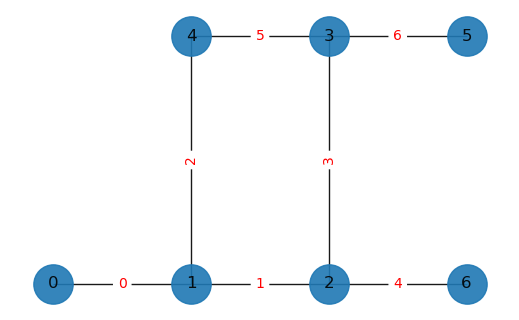

In [7]:
labels = dict(zip(nx_graph.edges, range(len(nx_graph.edges))))
print("Nodes ", nx_graph.nodes)
print("Edges ", nx_graph.edges)

plt.rcParams["figure.figsize"] = [5, 3]
nx.draw(nx_graph, with_labels=True, pos=positions, node_size=800, alpha=0.9)
nx.draw_networkx_edge_labels(nx_graph, pos=positions, edge_labels=labels, font_color="red")
plt.show()

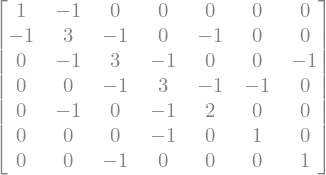

In [8]:
L = nx.laplacian_matrix(nx_graph.to_undirected()).toarray()
pprint(L)

### Solving the linear system (computation of pressure) 


The unkonw in this example is the pressure $p$: 

$$ L \, p = Q_b $$

with $Q_b$ the right hand side, representing for example the flow on the boundary nodes (boundary conditions).   
The solution of the above equation is up to a constant. It means that for any $k \in \mathbb{R}$, $p+k$ is a solution.

Let us define the boundary conditions i.e. the vector $\mathbf Q_b$

In [9]:
boundary_flows = np.zeros(nx_graph.number_of_nodes())
boundary_flows[0] = 1
boundary_flows[5] = -0.5
boundary_flows[6] = -0.5
boundary_nodes = [elem[0] for elem in nx_graph.degree if elem[1] == 1]
print("Boundary nodes with degree 1: ", boundary_nodes)
print("Flow on the boundary nodes: ", boundary_flows)

Boundary nodes with degree 1:  [0, 5, 6]
Flow on the boundary nodes:  [ 1.   0.   0.   0.   0.  -0.5 -0.5]


## Pseudo-inverse scipy pinv solution

In [10]:
L_inv = scipy_linalg.pinv(L)
pressure = L_inv @ boundary_flows
print("Pressure = ", pressure)

Pressure =  [ 1.44642857  0.44642857 -0.17857143 -0.30357143  0.07142857 -0.80357143
 -0.67857143]


### Scipy regularized solution

In [11]:
L_reg = L + 1e-14 * np.eye(7)
press = scipy_linalg.solve(L_reg, boundary_flows)
print("Pressure = ", press)
print("Difference is constant:  ", pressure - press)

Pressure =  [ 1.44336077  0.44336077 -0.18163923 -0.30663923  0.06836077 -0.80663923
 -0.68163923]
Difference is constant:   [0.0030678 0.0030678 0.0030678 0.0030678 0.0030678 0.0030678 0.0030678]


### Scipy-Sparse regularized solution

In [12]:
L_sparse_reg = csr_matrix(L_reg)
press_sparse = sparse_linalg.spsolve(L_sparse_reg, boundary_flows)
print("Pressure using scipy sparse solver: ", press_sparse)
print("The difference between the two pressures is a constant vector: \n ", pressure - press_sparse)

Pressure using scipy sparse solver:  [ 1.44698142  0.44698142 -0.17801858 -0.30301858  0.07198142 -0.80301858
 -0.67801858]
The difference between the two pressures is a constant vector: 
  [-0.00055285 -0.00055285 -0.00055285 -0.00055285 -0.00055285 -0.00055285
 -0.00055285]


## PETSc vector $Q_b$

In [13]:
print("Numpy array: ", boundary_flows)

Numpy array:  [ 1.   0.   0.   0.   0.  -0.5 -0.5]


In [14]:
b = PETSc.Vec().createWithArray(boundary_flows)
print("PETSc vector: ", b.getArray())

PETSc vector:  [ 1.   0.   0.   0.   0.  -0.5 -0.5]


Alternatively use: 

In [15]:
n = len(boundary_flows)

b = PETSc.Vec()
b.createSeq(n)  # For MPI use b.create(MPI_COMM) and b.setSizes(n)
b.setArray(boundary_flows)
b.setFromOptions()

In [16]:
print("PETSc vector: ", b.getArray())

PETSc vector:  [ 1.   0.   0.   0.   0.  -0.5 -0.5]


### PETSc Matrix L

We first create a sparse matrix in scipy. And then we create a sparse matrix with PETSc.

In [17]:
L_csr = csr_matrix(L)
A = PETSc.Mat().createAIJ(size=L_csr.shape, csr=(L_csr.indptr, L_csr.indices, L_csr.data))

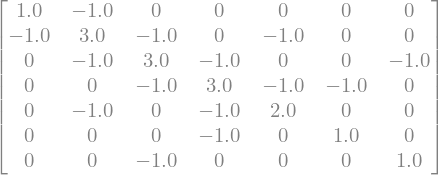

In [18]:
indptr, indices, data = A.getValuesCSR()
original_L = csr_matrix((data, indices, indptr), shape=(n, n)).toarray()
pprint(original_L)

Alternatively create directly from numpy matrix: 

In [19]:
A = PETSc.Mat().createAIJ([n, n])  # AIJ represents sparse matrix
A.setValues(range(n), range(n), L)
A.setUp()
A.assemble()  # to build the data structure

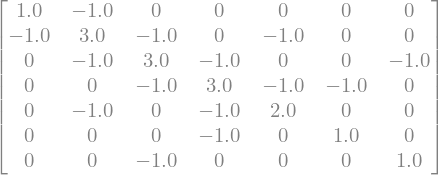

In [20]:
pprint(A.getValues(range(n), range(n)))

CreateAIJ also accepts an argument for using with MPI:
```python
COMM = PETSc.COMM_WORLD
J = PETSc.Mat().createAIJ(..., comm=COMM)
```

When using MPI use:

In [21]:
# A = PETSc.Mat()
# A.create(PETSc.COMM_WORLD)
# A.setSizes([N, M])
# A.setType('aij')
# A.setUp()

A few useful properties: 

In [22]:
print("Global size ", A.size)
print("Local size ", A.local_size)

Global size  (7, 7)
Local size  (7, 7)


In [23]:
A.isSymmetric()

True

In [24]:
diagonals = A.getDiagonal().array
diagonals

array([1., 3., 3., 3., 2., 1., 1.])

### Solving the linear system Ax=b with PETSc

In [25]:
x = PETSc.Vec().createSeq(7)
print("x: ", x.getArray())
x.array[:] = 1  # Assign a value
print("x: ", x.getArray())

x:  [0. 0. 0. 0. 0. 0. 0.]
x:  [1. 1. 1. 1. 1. 1. 1.]


In [26]:
ksp = PETSc.KSP().create()  # Krilov space object
ksp.setOperators(A)

ksp.setFromOptions()
print("Solving with default solver: ", ksp.getType())

Solving with default solver:  gmres


In [27]:
ksp.solve(b, x)
print("Solution vector x: ", x.getArray())
print("Difference is constant: ", pressure - x.getArray())

Solution vector x:  [ 1.57096538  0.57096538 -0.05403462 -0.17903462  0.19596538 -0.67903462
 -0.55403462]
Difference is constant:  [-0.12453681 -0.12453681 -0.12453681 -0.12453681 -0.12453681 -0.12453681
 -0.12453681]


In [28]:
ksp.destroy()

### Full options:

In [29]:
opts = PETSc.Options()

# solver
opts["ksp_type"] = "cg"  #  or "gmres"
# opts["ksp_gmres_restart"] = 100

# preconditioner
opts["pc_type"] = "gamg"
opts["pc_factor_shift_type"] = "NONZERO"
opts["pc_factor_shift_amount"] = PETSc.DECIDE

# progress
opts["ksp_monitor"] = None
# opts["monitor_true_residual"] = None
# opts["ksp_monitor_singular_value"] = None
# opts.delValue("ksp_monitor_singular_value")

ksp = PETSc.KSP().create()  # PETSc.COMM_WORLD as argument
ksp.setOperators(A)
ksp.rtol = 1e-12
ksp.atol = 1e-2
ksp.max_it = 5e2

ksp.setNormType(-1)  # https://petsc.org/main/manualpages/KSP/KSPNormType/

ksp.setConvergenceHistory()

# In alternative:
# ksp.setType(ksp_type)         # solver.  Use 'preonly' to use a direct method set in the preconditioner.
# ksp.getPC().setType('none')   # to ignore preconditioning
# ksp.setTolerances(atol=, rtol=, maxits=)
ksp.setFromOptions()

In [30]:
x = PETSc.Vec().createSeq(7)
ksp.solve(b, x)
print("Solution vector x: ", x.getArray())
print("Difference is constant: ", pressure - x.getArray())

  0 KSP Residual norm 2.712629736011e+00 
  1 KSP Residual norm 1.821503808426e-02 
  2 KSP Residual norm 2.261092099578e-16 
Solution vector x:  [ 2.1875  1.1875  0.5625  0.4375  0.8125 -0.0625  0.0625]
Difference is constant:  [-0.74107143 -0.74107143 -0.74107143 -0.74107143 -0.74107143 -0.74107143
 -0.74107143]


In [31]:
residual = A * x - b  # PETSc operations
print("Residuals: \n", residual.getArray())
print(f"The residual norm is: {residual.norm()}")  #  l2 Euclideian norm
print(f"The relative residual norm is: {residual.norm() / b.norm()}")

PETSc.Sys.Print(f"-> The KSP preconditioned residual norm is: {ksp.getResidualNorm()}")

Residuals: 
 [ 0.00000000e+00  2.22044605e-16  1.11022302e-16  1.11022302e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16]
The residual norm is: 4.710277376051325e-16
The relative residual norm is: 3.8459253727671276e-16
-> The KSP preconditioned residual norm is: 2.2610920995780914e-16


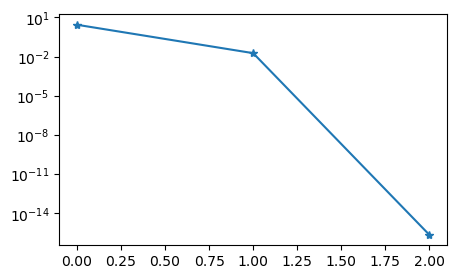

In [32]:
residuals = ksp.getConvergenceHistory()
plt.semilogy(residuals, marker="*")

## Solving the system, but faster:

- A direct method (e.g. LU decomposition) is the best approach when working with a small matrix. But we need to use the regularized version, otherwise a LU method fails with a singular matrix.
- For bigger matrices, when parallization is needed, it is mandatory to use an iterative solver.
- It turns out that GAMG is the best preconditioner in this case.
- The best solver is LGMRES
- We should also inform PETSc that the matrix is singular, by providing the kernel. In this way, the solution is searched in an optimized way.

### LU decomposition with PETSc 

In [33]:
# Regularized matrix
A_r = PETSc.Mat().createAIJ([n, n])
A_r.setValues(range(n), range(n), L_reg)
A_r.setUp()
A_r.assemble()

In [34]:
ksp = PETSc.KSP().create()  # Krilov space object
ksp.setOperators(A_r)
ksp.setFromOptions()

ksp.setType("preonly")
# ksp.setGMRESRestart(100)
ksp.getPC().setType("lu")
ksp.setTolerances(atol=1e-4, rtol=1e-12, max_it=500)

x = PETSc.Vec().createSeq(7)
ksp.solve(b, x)
print("Solution vector x: ", x.getArray())
print("Difference is constant: ", pressure - x.getArray())

  0 KSP Residual norm 1.224744871392e+00 
  1 KSP Residual norm 1.551583845780e-16 
Solution vector x:  [ 1.44579876  0.44579876 -0.17920124 -0.30420124  0.07079876 -0.80420124
 -0.67920124]
Difference is constant:  [0.00062982 0.00062982 0.00062982 0.00062982 0.00062982 0.00062982
 0.00062982]


### LGMRES and kernel info

With the iterative solver there is no need to use the regularized matrix.

In [35]:
# create the nullspace of the laplacian
null_vec = PETSc.Vec().createSeq(7)
null_vec.array[:] = 1

null_space = PETSc.NullSpace().create(null_vec)
A.setNullSpace(null_space)

Let's check that `null_vec` belongs to the kernel of A:

In [36]:
imag = A * null_vec
imag.getArray()

array([0., 0., 0., 0., 0., 0., 0.])

In [37]:
ksp = PETSc.KSP().create()  # Krilov space object
ksp.setOperators(A)
ksp.setFromOptions()

ksp.setType("lgmres")
ksp.setGMRESRestart(10)
ksp.getPC().setType("gamg")
ksp.setTolerances(atol=1e-4, rtol=1e-12, max_it=500)

x = PETSc.Vec().createSeq(7)
ksp.solve(b, x)
print("Solution vector x: ", x.getArray())
print("Difference is constant: ", pressure - x.getArray())

  0 KSP Residual norm 1.875192900723e+00 
  1 KSP Residual norm 1.818982079082e-02 
  2 KSP Residual norm 1.775135636435e-16 
Solution vector x:  [ 1.44642857  0.44642857 -0.17857143 -0.30357143  0.07142857 -0.80357143
 -0.67857143]
Difference is constant:  [2.22044605e-16 8.32667268e-16 1.36002321e-15 9.99200722e-16
 9.02056208e-16 6.66133815e-16 1.33226763e-15]


### Sources for using PETSc

[1] https://snyk.io/advisor/python/petsc4py/functions/petsc4py.PETSc.Mat

[2] https://petsc.org/release/manual/ksp/

[3] https://tbetcke.github.io/hpc_lecture_notes/petsc_for_sparse_systems.html
